In [1]:
import os
import time
import platform
import numpy as np
import matplotlib.pyplot as plt

import read_atlas_layer_points as rlp

In [2]:
pid_index_range= [1]
number_of_atlas = 31;

In [3]:
input_folder, main_folder, manual_seg_filename, atlas_filenames = None, None, None, None

if platform.system() == 'Windows':
    input_folder = 'C:/D/dev/data/20171204_cirrus_manual'
    main_folder = 'C:/D/dev/data/20171205_cirrus_manual_results'
    manual_seg_filename = 'C:/D/dev/Xnorm/experiments/oct/20171204_manual_segmentation/filenames.txt'
    atlas_filenames = 'C:/D/dev/Xnorm/experiments/oct/20170830_large_healthy_data_proc/cirrus_od_altas_folder_linux_iacl.txt'
elif platform.system() == 'Linux':
    input_folder = '/iacl/pg17/ja/data/20171204_cirrus_manual/'
    main_folder = '/iacl/pg17/ja/data/20171205_cirrus_manual_results/'
    manual_seg_filename = '/home/ja/dev/Xnorm/experiments/oct/20171204_manual_segmentation/filenames.txt'
    atlas_filenames = '/home/ja/dev/Xnorm/experiments/oct/20170830_large_healthy_data_proc/cirrus_od_altas_folder_linux_iacl.txt'

pids, image_prefixes = rlp.read_manual_segmentation_oct_files(manual_seg_filename)
atlas_folders, atlas_subfolders = rlp.read_atlas_images_files(atlas_filenames)

#print('PID: {}\nImagePrefixes:{}'.format(pids, image_prefixes))
#print('Atlas folders:{}\nAtlas subfolders:{}'.format(atlas_folders, atlas_subfolders))

In [4]:
shuffle=False
used_pids = []
for idx in pid_index_range: used_pids.append(pids[idx])    

deformed_layer_shuffle_points4pids = rlp.get_layer_points_for_pids(used_pids, 
                                    atlas_subfolders, shuffle, main_folder, number_of_atlas)

Using 31 atlases


In [5]:
print('{}, {}'.format(pids[idx], image_prefixes[pid_index_range[0]]))
fname = '%s_flatten_result.csv' % image_prefixes[pid_index_range[0]]
filename = os.path.join(input_folder, fname)
print('folder {}\nfile{}'.format(input_folder, filename))
reference_labeled_points = rlp.read_layer_points(filename, shuffle)

P1092977057, P1092977057_Macular Cube 512x128_2-15-2012_16-13-29_OS_sn10264_cube_z
folder /iacl/pg17/ja/data/20171204_cirrus_manual/
file/iacl/pg17/ja/data/20171204_cirrus_manual/P1092977057_Macular Cube 512x128_2-15-2012_16-13-29_OS_sn10264_cube_z_flatten_result.csv


In [6]:
print(reference_labeled_points['1'][65536-5:, :])
start_npnt = 65536*30
deformed_layer_shuffle_points4pids['P1092977057']['1'][start_npnt-5:start_npnt, :]

[[0.790254 5.9319   5.9944  ]
 [0.791324 5.9436   5.9944  ]
 [0.792297 5.9553   5.9944  ]
 [0.793071 5.967    5.9944  ]
 [0.793594 5.9787   5.9944  ]]


array([[0.708042, 6.13453 , 5.75754 ],
       [0.707691, 6.14623 , 5.75755 ],
       [0.707274, 6.15794 , 5.75756 ],
       [0.706949, 6.16964 , 5.75756 ],
       [0.706774, 6.18134 , 5.75757 ]], dtype=float32)

In [7]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

class Dataset:
    def __init__(self, data_points, reference_labeled_points, label, val_frac=0.25,\
                 do_normalize=True, num_pnt_per_boundary = 512*128):
        
        self.input_dim = num_pnt_per_boundary*2
        self.output_dim = num_pnt_per_boundary
        
        train_data = data_points[label]
        test_data = reference_labeled_points[label]
        
        self.scaler = MinMaxScaler().fit(np.concatenate((train_data, test_data)))
        #print('Scaler mean: ', std_scaler.mean_, ' scale: ', std_scaler.scale_)
        train_data_scaled = self.scaler.fit_transform(train_data)
        test_data_scaled = self.scaler.fit_transform(test_data)
        #print('Train data size ', train_data_scaled.shape)
        #print('Original test data: \n', test_data[10:12, :])
        #print('\nScaled test data: \n', test_data_scaled[10:12, :])
        #print('\nUnscaled test data: \n', self.scaler.inverse_transform(test_data_scaled[10:12, :]))
        #y_scaler.inverse_transform(predicted)
        
        print('Train yz before reshape \n', train_data_scaled[:4, 1:])
        self.train_yz = train_data_scaled[:, 1:].reshape((-1, self.input_dim))
        self.train_x = train_data_scaled[:,0].reshape((-1, self.output_dim))
        print('Train yz after reshape \n', self.train_yz[0, :8])
        print('Train yz shape ', self.train_yz.shape, ' train x shape ', self.train_x.shape)
        
        self.num_ref_points = test_data_scaled.shape[0]
        if val_frac > 1e-8:
            split_idx = int(number_of_reference_points*(1 - val_frac))

            self.test_yz, self.valid_yz = test_data_scaled[:split_idx, 1:].reshape((-1, 1)),\
                                          test_data_scaled[split_idx:, 1:].reshape((-1, 1))
            self.test_x, self.valid_x = test_data_scaled[:split_idx, 0], \
                                        test_data_scaled[split_idx:, 0]
        else:
            self.test_yz, self.valid_yz = None, test_data_scaled[:, 1:].reshape((1,- 1))
            self.test_x, self.valid_x = None, test_data_scaled[:, 0].reshape((1,- 1))        
            
        print('Validation yz shape ', self.valid_yz.shape, ' validation x shape ', self.valid_x.shape)
        
    def batches(self, batch_size):
        n_batches = len(self.train_x)//batch_size
        for ii in range(0, len(self.train_x), batch_size):
            yz = self.train_yz[ii:ii+batch_size, :]
            x = self.train_x[ii:ii+batch_size]
            
            yield yz, x

In [8]:
# data
dataset = Dataset(deformed_layer_shuffle_points4pids[used_pids[0]],
                  reference_labeled_points, '1', val_frac=0.0, do_normalize=True)
print(type(dataset.train_x))
print(dataset.scaler)

Train yz before reshape 
 [[2.3064176e-02 0.0000000e+00]
 [2.4927836e-02 3.0547380e-07]
 [2.6791334e-02 7.5995922e-07]
 [2.8654834e-02 1.0728836e-06]]
Train yz after reshape 
 [2.3064176e-02 0.0000000e+00 2.4927836e-02 3.0547380e-07 2.6791334e-02
 7.5995922e-07 2.8654834e-02 1.0728836e-06]
Train yz shape  (31, 131072)  train x shape  (31, 65536)
Validation yz shape  (1, 131072)  validation x shape  (1, 65536)
<class 'numpy.ndarray'>
MinMaxScaler(copy=True, feature_range=(0, 1))


In [9]:
print(dataset.train_x[0])
print(dataset.train_x[1])
print(dataset.train_x[2])
print(dataset.valid_x)

[0.7979355  0.79459834 0.7914548  ... 0.5132446  0.51263237 0.5125148 ]
[0.64644575 0.64461374 0.64223075 ... 0.46842074 0.4745648  0.47907043]
[0.85466456 0.84704566 0.83781457 ... 0.49079204 0.4976809  0.5044167 ]
[[0.7724314  0.76861286 0.7657361  ... 0.90901375 0.9144969  0.9182024 ]]


In [12]:
import sys
import logging
import pickle

#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sknn.mlp import Regressor, Layer, Native
from lasagne import layers as lasagne, nonlinearities as nl

In [13]:
input_dim, output_dim = 131072, 65536
batch_size = 1
n_iter=500
loss_type='mse'
#learning_rates = [1e2]#[1e9, 1e8, 1e7, 1e6, 1e5]#[10, 1, 0.1, 0.01, 0.001, 1e-4, 1e-5]
learning_rate = 10
hidden_units_list = [16, 32, 64, 128, 256, 512, 1024]
#hidden_units = [16]
dropouts = []
normalizes = []
activation="Tanh"
valid_set = (dataset.valid_yz, dataset.valid_x)

In [14]:
from itertools import permutations

all_hidden_units = []

#for hunit in hidden_units_list:
#    all_hidden_units.append([hunit])

all_hidden_units.append([1024])
for i in range(4):
    for j in range(i+1, len(hidden_units_list)-3+i, 1):
        all_hidden_units.append([hidden_units_list[j], hidden_units_list[i]])

all_hidden_units    

#l = list(permutations(hidden0_units))
#print(l)
str(all_hidden_units[8])
'_'.join([str(n) for n in all_hidden_units[8]])

'256_64'

In [15]:
def create_layers(hidden_units, dropouts=None, normalizes=None, activation="Tanh", output_dim=65536):
    layers = []
    for idx, hu in enumerate(hidden_units):
        if dropouts and normalizes and dropouts[idx] and normalizes[idx]:
            layers.append(Layer(activation, units=hu, dropout=dropouts[idx] ,
                                normalize=normalizes[idx]))
        elif dropouts and dropouts[idx]:
            layers.append(Layer(activation, units=hu, dropout=dropouts[idx] ))
        elif normalizes and normalizes[idx]:
            layers.append(Layer(activation, units=hu, normalize=normalizes[idx]))
        else:
            layers.append(Layer(activation, units=hu))
    layers.append(Layer("Linear", units= output_dim))     
    
    return layers

In [16]:
import csv

def write_log_error(filename, errors):
    with open(filename, "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for error in errors:
            writer.writerow(error)

In [17]:
def mean_absolute_error(dataset, X, y, prediction):
    X= X.reshape(-1, 2)
    y = y.reshape(-1, 1)
    prediction = prediction.reshape(-1,1)
    #print('X ', X.shape, ' y ', y.shape, ' pred ', prediction.shape)
    reference = np.hstack((y, X))
    prediction = np.hstack((prediction, X))
    #print('Before Reference \n', reference, '\nPrediction\n', prediction)
    reference = dataset.scaler.inverse_transform(reference)
    prediction = dataset.scaler.inverse_transform(prediction)
    #print('After Reference \n', reference, '\nPrediction\n', prediction)
    differences = np.abs(prediction[:, 0] - reference[:, 0])
    mad = np.mean(differences)
    return mad, max(differences), min(differences)

In [ ]:
import os

logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)    

hunit_sen_filename = os.path.join(main_folder, '20180121_P1092977057_nn','hunit_sensitivity.csv')

#for lr in learning_rates:
for hidden_units in all_hidden_units:
    
    hunit_config = '_'.join([str(n) for n in hidden_units])
    
    errors = []
    def store_stats(avg_valid_error, avg_train_error, **_):
        errors.append((avg_valid_error, avg_train_error))
    
    layers = create_layers(hidden_units, dropouts, normalizes, activation, output_dim)
    
    nn = Regressor(
            layers = layers,
            learning_rate=learning_rate,
            learning_rule='adadelta',
            batch_size = batch_size,
            #valid_size = 0.25,
            valid_set = valid_set,
            loss_type=loss_type,
            n_iter=n_iter,
            verbose=True,
            callback={'on_epoch_finish': store_stats})
    try:
        nn.fit(dataset.train_yz, dataset.train_x)
    except KeyboardInterrupt:
        pass
    
    filename = os.path.join(main_folder, '20180121_P1092977057_nn','error_log_hunits%s.csv' % hunit_config)
    write_log_error(filename, errors)
    
    pickle_filename = os.path.join(main_folder, '20180121_P1092977057_nn', 'nn_hunits%s.pkl' % hunit_config)
    pickle.dump(nn, open(pickle_filename, 'wb'))
    
    prediction = nn.predict(dataset.valid_yz)
    rss = np.mean((prediction - dataset.valid_x) ** 2)
    var_score = nn.score(dataset.valid_yz, prediction)
    
    mad, max_ad, min_ad = mean_absolute_error(dataset, dataset.valid_yz, dataset.valid_x, prediction)
    
    print("Residual sum of squares: %.2f"% rss)
    print('Variance score: %.2f' %  var_score) # Explained variance score: 1 is perfect prediction
    
    with open(hunit_sen_filename, "a") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow((hunit_config, mad, max_ad, min_ad, rss, var_score))
            
    

Initializing neural network with 2 layers, 131072 inputs and 65536 outputs.
  - Dense: Tanh       Units:  1024
  - Dense: Linear     Units:  65536

Training on dataset of 31 samples with 6,094,848 total size.
  - Train: 31         Valid: 1   
  - Terminating loop after 500 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1          4.336e-02             2.186e-02        135.6s                                     
    2          7.905e-03             2.200e-02        118.8s                                                
    3          7.843e-03             2.658e-02        119.1s                                                
    4          7.993e-03             2.888e-02        117.3s                                                           
    5          7.776e-03             2.004e-02        116.0s                                     
 

   11          1.636e-02             2.261e-02          5.6s                                     
   12          1.360e-02             2.181e-02          5.7s                                     
   13          1.160e-02             2.142e-02          5.8s                                     
   14          1.015e-02             2.128e-02          5.4s                                     
   15          9.091e-03             2.132e-02          5.8s                                                
   16          8.328e-03             2.148e-02          5.5s                                                
   17          7.777e-03             2.171e-02          5.5s                                                
   18          7.378e-03             2.196e-02          5.7s                                                
   19          7.089e-03             2.222e-02          5.6s                                                
   20          6.877e-03             2.245e-02          5.3s   

  - Dense: Linear     Units:  65536

Training on dataset of 31 samples with 6,094,848 total size.
  - Train: 31         Valid: 1   
  - Terminating loop after 500 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1          2.308e-01             1.405e-01         10.8s                                     
    2          1.269e-01             7.771e-02         10.6s                                     
    3          7.085e-02             4.662e-02         10.4s                                     
    4          4.083e-02             3.150e-02         10.8s                                     
    5          2.476e-02             2.473e-02         11.2s                                     
    6          1.620e-02             2.213e-02         10.8s                                     
    7          1.161e-02             2.133e-02         10.

    1          1.881e-01             8.183e-02         21.4s                                     
    2          5.945e-02             3.282e-02         21.6s                                     
    3          2.175e-02             2.229e-02         21.3s                                     
    4          1.083e-02             2.123e-02         21.3s                                     
    5          7.685e-03             2.243e-02         21.3s                                                
    6          6.818e-03             2.313e-02         21.5s                                                
    7          6.537e-03             2.363e-02         21.8s                                                
    8          6.447e-03             2.401e-02         22.3s                                                
    9          6.419e-03             2.412e-02         21.7s                                                
   10          6.406e-03             2.433e-02         22.8s   

   12          6.503e-03             2.409e-02         42.9s                                                           

Early termination condition fired at 12 iterations.
Residual sum of squares: 0.02
Variance score: 1.00
Initializing neural network with 3 layers, 131072 inputs and 65536 outputs.
  - Dense: Tanh       Units:  1024
  - Dense: Tanh       Units:  128 
  - Dense: Linear     Units:  65536

Training on dataset of 31 samples with 6,094,848 total size.
  - Train: 31         Valid: 1   
  - Terminating loop after 500 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1          1.336e-01             3.389e-02         79.2s                                     
    2          1.739e-02             2.133e-02         78.8s                                     
    3          7.405e-03             2.298e-02         81.6s                    

(0, 0.4)

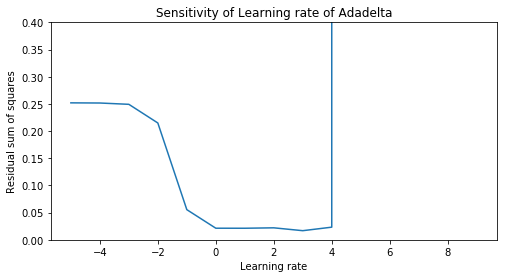

In [174]:
%matplotlib inline

# learning rate sensitivity
def read_learning_rate_sensitivity_file(filename):

    sensitivity = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if not row: continue
            sensitivity.append(np.asarray(row, dtype=np.float32))
    return np.asarray(sensitivity)

lr_sen_filename = os.path.join(main_folder, '20180121_P1092977057_nn','lr_sensitivity.csv')
sensitivity = read_learning_rate_sensitivity_file(lr_sen_filename)


fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)
ax1.plot(np.log10(sensitivity[:, 0]), sensitivity[:, 1])
ax1.set_title('Sensitivity of Learning rate of Adadelta')
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('Residual sum of squares')
ax1.set_ylim(0, 0.4)
#ax1.set_xlim(0, 25)

In [147]:
lr_sen_filename = os.path.join(main_folder, 'lr_sensitivity.csv')
rss = np.mean((nn.predict(dataset.valid_yz) - dataset.valid_x) ** 2)
var_score = nn.score(dataset.valid_yz, dataset.valid_x)

print("Residual sum of squares: %.2f"% rss)
print('Variance score: %.2f' %  var_score) # Explained variance score: 1 is perfect prediction

with open(lr_sen_filename, "a") as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    writer.writerow((rss, var_score))

Residual sum of squares: 0.02
Variance score: 0.00


In [148]:
os.path.join(main_folder, '20180121_P1092977057_nn','lr_sensitivity.csv')

'C:/D/dev/data/20171205_cirrus_manual_results\\20180121_P1092977057_nn\\lr_sensitivity.csv'

In [14]:
logging.basicConfig(
            format="%(message)s",
            level=logging.DEBUG,
            stream=sys.stdout)

#layers = [ Native(lasagne.DenseLayer, num_units= 16, nonlinearity=nl.leaky_rectify),
#           Layer("Linear")]
layers = [ Layer("Tanh", units= 16),
           Layer("Linear", units= output_dim)]

nn = Regressor(
    layers = layers,
    #learning_rate=0.02,
    learning_rule='adadelta',
    batch_size = batch_size,
    #valid_size = 0.25,
    valid_set = (dataset.valid_yz, dataset.valid_x),
    loss_type=loss_type,
    n_iter=n_iter,
    verbose=True)
# normalize = ['batch', 'weights']
# regularize = [None, 'dropout'] --> dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7]
#pickle.dump(nn, open('nn.pkl', 'wb'))

In [21]:
param_grid = {'loss_type':['mse', 'mae'],
              'hidden0_units': [16, 32, 64, 128, 256, 512, 1024],
              'hidden0_dropout': [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
              'hidden0_normalize': [None, 'batch', 'weights']}
gs = GridSearchCV(nn, param_grid=param_grid, iid=False, n_jobs=1, verbose=100,
                  scoring='neg_mean_squared_error', return_train_score =False)

In [15]:
#gs.fit(X_train, y_train)
try:
    nn.fit(dataset.train_yz, dataset.train_x)
except KeyboardInterrupt:
    pass

Initializing neural network with 2 layers, 131072 inputs and 65536 outputs.
  - Dense: Rectifier  Units:  16  
  - Dense: Linear     Units:  65536

Training on dataset of 10 samples with 1,966,080 total size.
  - Train: 10         Valid: 1   
  - Terminating loop after 500 total iterations.
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            3.488e-01             2.520e-01          1.1s
    2         ..............................................                                                            3.486e-01             2.519e-01          1.1s
    3         ..............................................                                                            3.486e-01             2.518e-01          1.1s
    4         .......................

In [25]:
nn

Regressor(batch_size=1, callback=None, debug=False, dropout_rate=None,
     f_stable=0.001,
     hidden0=<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=16>,
     layers=[<sknn.nn.Layer `Rectifier`: frozen=False, name='hidden0', units=16>, <sknn.nn.Layer `Linear`: frozen=False, name='output', units=65536>],
     learning_momentum=0.9, learning_rate=0.01, learning_rule='adadelta',
     loss_type='mse', n_iter=500, n_stable=10, normalize=None,
     output=<sknn.nn.Layer `Linear`: frozen=False, name='output', units=65536>,
     parameters=None, random_state=None, regularize=None,
     valid_set=(array([[ 0.,  0., ...,  1.,  1.]], dtype=float32), array([[ 0.77243,  0.76861, ...,  0.9145 ,  0.9182 ]], dtype=float32)),
     valid_size=0.0, verbose=True, warning=None, weight_decay=None)

In [39]:
print(scaled_target_yz.shape)
predict_x = nn.predict(scaled_target_yz)
print('Predict ', predict_x, ' target ', scaled_target_x)

(1, 131072)
Predict  [[ 0.83329676  0.82093655  0.82227153 ...,  0.58367749  0.55042307
   0.56696111]]  target  [[ 0.77243137  0.76861286  0.7657361  ...,  0.90901375  0.9144969
   0.9182024 ]]


In [38]:
predict_x = nn.predict(dataset.valid_yz)
print('Predict ', predict_x, ' target ', dataset.valid_x)

Predict  [[ 0.83329676  0.82093655  0.82227153 ...,  0.58367749  0.55042307
   0.56696111]]  target  [[ 0.77243137  0.76861286  0.7657361  ...,  0.90901375  0.9144969
   0.9182024 ]]


In [37]:
#print(dataset.train_x[0].reshape((-1, 65536)))
predict_x = nn.predict(dataset.train_yz[0].reshape((-1, 131072)))
print('Predict ', predict_x, ' target ', dataset.train_x[0].reshape((-1, 65536)))

Predict  [[ 0.80821403  0.79714073  0.79811453 ...,  0.56630172  0.53427368
   0.5499854 ]]  target  [[ 0.86423683  0.86062241  0.85721779 ...,  0.55589056  0.55522776
   0.55510044]]


In [27]:
print("Residual sum of squares: %.2f"
      % np.mean((nn.predict(dataset.valid_yz) - dataset.valid_x) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % nn.score(dataset.valid_yz, dataset.valid_x))

Residual sum of squares: 0.03
Variance score: 0.00


In [ ]:
gs.cv_results_

In [ ]:
print('Best estimator ', gs.best_estimator_)
print('Best params ', gs.best_params_)
print('Best index ', gs.best_index_)
print('Best score ', gs.best_score_)


In [ ]:
print('score =', nn.score(X, y))

In [ ]:
pickle.dump(nn, open('nn.pkl', 'wb'))
#nn = pickle.load(open('nn.pkl', 'rb'))

In [ ]:
y_example = nn.predict(X_example)